installing dependencies:
1. torch: pytorch
2. torchvision: utilities for images like dataset and transformations
3. timm: pretrained models library - efficientNet
4. kaggle: to download the dataset directly

In [ ]:
! pip install -q kaggle timm torch torchvision

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{\n\t"username": "anvishah11",\n\t"key": "KGAT_759174e60c7220d319017cc592447e6c"\n}'}

In [ ]:
!mkdir -p /root/.kaggle
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!cat /root/.kaggle/kaggle.json

{
	"username": "anvishah11",
	"key": "KGAT_759174e60c7220d319017cc592447e6c"
}

In [ ]:
!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images

Dataset URL: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
License(s): other
 63% 66.0M/105M [00:00<00:00, 688MB/s]
100% 105M/105M [00:00<00:00, 758MB/s] 


In [ ]:
!mkdir -p data
!unzip -q cifake-real-and-ai-generated-synthetic-images.zip -d data
!ls data

test  train


PREPARING THE DATA : augmentation, creating the dataset, preparing the dataloader and ensuring device=GPU

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader #dataloader is used to be able to easily batch and shuffle the data so to make validation sets
from torchvision import datasets, transforms # datasets.Imagefolder to load the images directly and trnasformations for augmentation
import timm

In [ ]:
# can be edited transformations:

train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness = 0.1, contrast= 0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229,0.224,0.225]) #ImageNet normalisation
])

test_transforms=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229,0.224,0.225])
])

In [ ]:
train_data = datasets.ImageFolder(root='data/train', transform=train_transforms)
test_data  = datasets.ImageFolder(root='data/test',  transform=test_transforms)

print("Classes:", train_data.classes)

Classes: ['FAKE', 'REAL']


In [ ]:
from torch.utils.data import random_split

val_size = int(0.2 * len(train_data))     # 20% of training for validation
train_size = len(train_data) - val_size

train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

print("Train:", len(train_dataset))
print("Val:", len(val_dataset))
print("Test:", len(test_data))

Train: 80000
Val: 20000
Test: 20000


In [ ]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # to ensure that we are using GPU (cude: is the gpu provided by NVDIA)
print("using device: ", device)

using device:  cuda


LOADING THE MODEL

In [ ]:
# import timm

# # List all available EfficientNetV2 models
# efficientnet_models = timm.list_models('*efficientnetv2*', pretrained=True)
# print("Available EfficientNetV2 models:")
# for model_name in efficientnet_models:
#     print(f"  - {model_name}") ---------------- only did to find out the model name

In [ ]:

model=timm.create_model('tf_efficientnetv2_b0.in1k', pretrained=True)
#edit the fc layers of the cater to our problem. normally the vecotr size out of cnn is 1280 we reduce to 256
# introduce dropout to reduce the overfitting
# change the 1000 final classes that the model classifies into 2 classes
model.classifier = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(model.classifier.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256,2)
)

model=model.to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/28.8M [00:00<?, ?B/s]

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

In [ ]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [ ]:
from tqdm import tqdm
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=5):
    best_acc = 0
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        # ------------------ TRAIN ------------------
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / total
        train_acc = correct / total
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")

        # ------------------ VALIDATION ------------------
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= total
        val_acc = correct / total
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # Scheduler step
        scheduler.step()

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")
            print("Saved Best Model ✅")

    print(f"\nTraining complete! Best Val Accuracy: {best_acc:.4f}")


In [ ]:
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=5)


Epoch 1/5


100%|██████████| 2500/2500 [06:48<00:00,  6.12it/s]

Train Loss: 0.1337 | Train Acc: 0.9483


Val Loss: 0.0660 | Val Acc: 0.9767
Saved Best Model ✅

Epoch 2/5


100%|██████████| 2500/2500 [06:41<00:00,  6.23it/s]

Train Loss: 0.0645 | Train Acc: 0.9756


Val Loss: 0.0574 | Val Acc: 0.9781
Saved Best Model ✅

Epoch 3/5


100%|██████████| 2500/2500 [06:47<00:00,  6.14it/s]

Train Loss: 0.0435 | Train Acc: 0.9841


Val Loss: 0.0571 | Val Acc: 0.9819
Saved Best Model ✅

Epoch 4/5


100%|██████████| 2500/2500 [06:45<00:00,  6.16it/s]

Train Loss: 0.0288 | Train Acc: 0.9895


Val Loss: 0.0502 | Val Acc: 0.9830
Saved Best Model ✅

Epoch 5/5


100%|██████████| 2500/2500 [06:44<00:00,  6.18it/s]

Train Loss: 0.0206 | Train Acc: 0.9926


Val Loss: 0.0465 | Val Acc: 0.9846
Saved Best Model ✅

Training complete! Best Val Accuracy: 0.9846


In [ ]:
# 4. Download to your local machine
from google.colab import files
files.download("best_model.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

STOPPED AT 5TH EPOCH TO PREVENT OVERFITTING

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Final Test Accuracy:", correct / total)


Final Test Accuracy: 0.98425


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

model.eval()

all_labels =[]
all_preds=[]

with torch.no_grad():
  for images,labels in test_loader:
    images,labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs,1)

    all_labels.extend(labels.cpu().numpy())
    all_preds.extend(preds.cpu().numpy())

print("classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=['REAL','FAKE']))

classification Report:

              precision    recall  f1-score   support

        REAL       0.98      0.99      0.98     10000
        FAKE       0.99      0.98      0.98     10000

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000



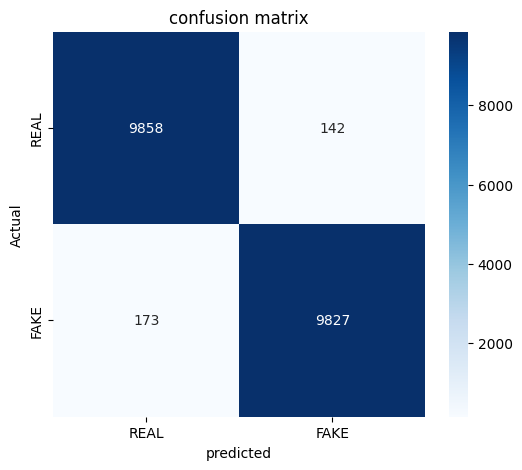

In [ ]:
cm = confusion_matrix(all_labels,all_preds)
plt.figure(figsize =(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=['REAL','FAKE'],yticklabels=['REAL','FAKE'])
plt.xlabel("predicted")
plt.ylabel("Actual")
plt.title("confusion matrix")
plt.show()

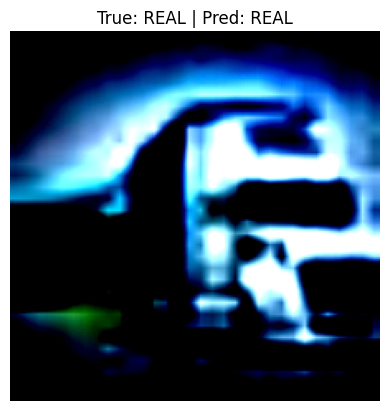

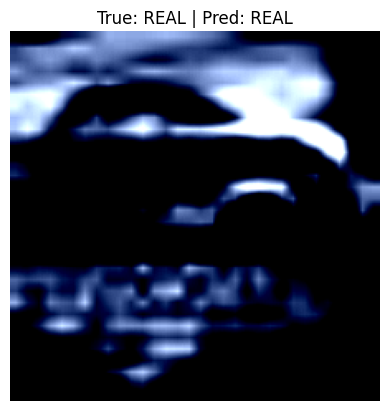

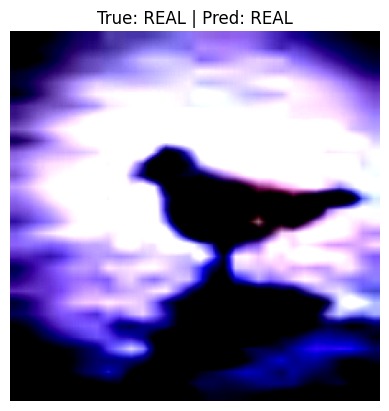

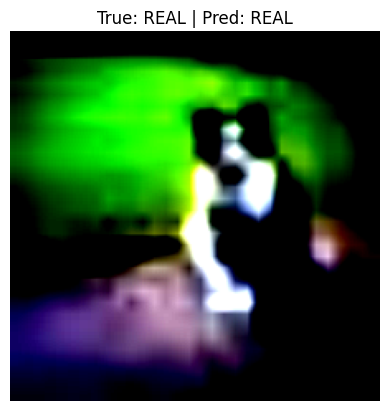

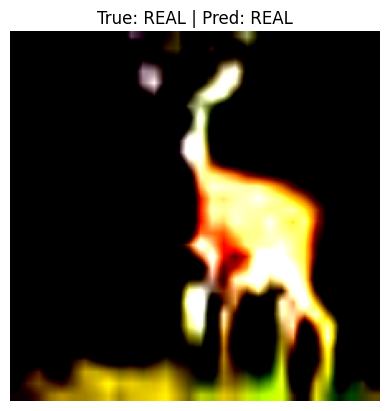

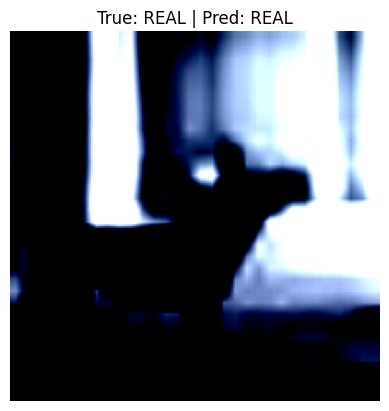

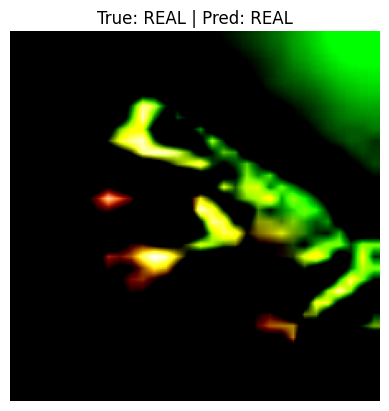

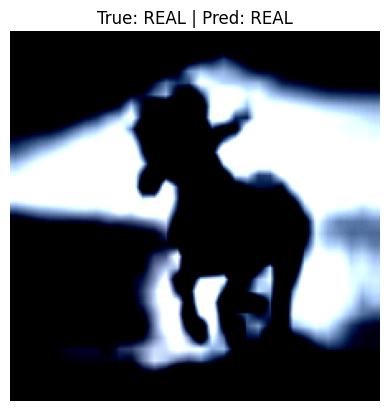

In [ ]:
import torchvision

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Pick a batch
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)

# Show first 8 images
for i in range(8):
    img = images[i].cpu()
    true_label = 'REAL' if labels[i]==0 else 'FAKE'
    pred_label = 'REAL' if preds[i]==0 else 'FAKE'
    imshow(img, f"True: {true_label} | Pred: {pred_label}")